## Rt_analysis_by_race

Here, we estimate the effective reproductive number of cases in each state based on racial breakdowns.

In [26]:
using Plots, Turing, StatsPlots, Distributions, CSV, DataFrames, Dates

## Load data

In [352]:
# Serial interval of novel coronavirus (COVID-19) infections
# Nishiura. T

# The author's fit the serial interval using a log-normal distribution.
function generation_time(n_days = 20)
    # Generate best fit log-norm to serial interval (Nishiura 2020)
    mean_serial = 4.7
    sd_serial = 2.9
    
    γ = 1 + sd_serial^2 / mean_serial^2
    dist = LogNormal(log(mean_serial / sqrt(γ)), sqrt(log(γ)))
    gen = cdf(dist, [1:n_days])
    gen = diff(gen[1])
    gen /= sum(gen)
end

g = generation_time(20)
# Our data is given every 3 days
g = [sum(g[1:3]), sum(g[4:6]), sum(g[7:9]), sum(g[10:12]), sum(g[13:15]), sum(g[16:18]), sum(g[19])]
scatter(g,
    title = "Generation Interval (Nishura)",
    ylabel = "Probability Mass",
    label = false,
    xlabel = "x")

NegativeBinomial2(μ, k) = NegativeBinomial(k,  k/(k + μ))

NegativeBinomial2 (generic function with 1 method)

In [355]:
function load_data()
    Cases = DataFrame(CSV.File("../data//3_covidtracking/Race_Date_CTP.csv"))
    transform!(Cases, :Date =>  ByRow(x -> Date(string(x), "yyyymmdd"))  => :Date)
    sort!(Cases, :Date)
        
    Cases = coalesce.(Cases, 0.0)    
    
    return Cases
end

load_data (generic function with 1 method)

In [356]:
Cases = load_data();

┌ Warning: thread = 7 warning: only found 53 / 54 columns around data row: 5104. Filling remaining columns with `missing`
└ @ CSV /Users/marlinfiggins/.julia/packages/CSV/YUbbG/src/file.jl:603


In [357]:
function load_state(state_names, DF)
    filter(row -> row.State in state_names, DF)
end

STATE = "MI"
STATE_DATA = load_state([STATE], Cases);

In [358]:
function negs_to_zero(VEC)
    VEC[VEC .< 0] .= 0.0
    return VEC
end

negs_to_zero (generic function with 1 method)

In [359]:
function break_by_race(STATE_DATA; negs = true)
    num_smooth = 1
    CtAsian = convert.(Float64, diff(STATE_DATA[!, :Cases_Asian]))
    CtWhite = convert.(Float64, diff(STATE_DATA[!, :Cases_White]))
    CtBlack = convert.(Float64, diff(STATE_DATA[!, :Cases_Black]))
    #CtAIAN = convert.(Float64, diff(STATE_DATA[!, :Cases_AIAN]))

    DtAsian = convert.(Float64, (STATE_DATA[!, :Deaths_Asian]))
    DtWhite = convert.(Float64, (STATE_DATA[!, :Deaths_White]))
    DtBlack = convert.(Float64, (STATE_DATA[!, :Deaths_Black]))
    
        
    if negs == true
        num_smooth = 6

        CtAsian = negs_to_zero(CtAsian)
        CtWhite = negs_to_zero(CtWhite)
        CtWhite = negs_to_zero(CtWhite)
        
        CtAsian = round.(moving_average(CtAsian, num_smooth))
        CtWhite = round.(moving_average(CtWhite, num_smooth))
        CtBlack = round.(moving_average(CtBlack, num_smooth))
        #CtAIAN = negs_to_zero(CtAIAN)
    end
    
    DateVec = STATE_DATA[!, :Date][(num_smooth+1):end];

    return CtAsian, CtWhite, CtBlack, DtAsian, DtWhite, DtBlack, DateVec
end

break_by_race (generic function with 1 method)

In [360]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

moving_average (generic function with 1 method)

In [361]:
CtAsian, CtWhite, CtBlack, DtAsian, DtWhite, DtBlack, DateVec = break_by_race(STATE_DATA; negs = true);

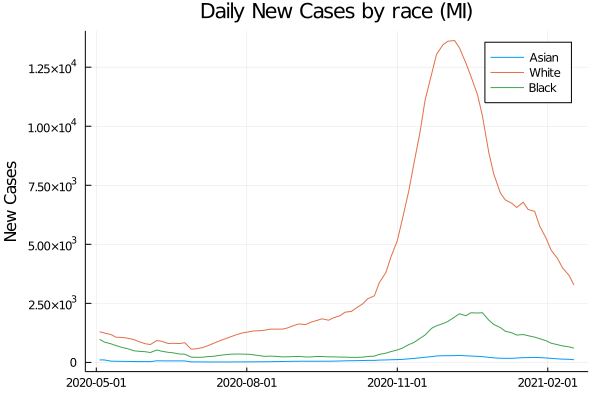

In [362]:
plot(DateVec, 
    CtAsian,
    label = "Asian",
    title = "Daily New Cases by race (" * STATE * ")",
    ylab = "New Cases")
plot!(DateVec,
    CtWhite,
    label = "White")
plot!(DateVec,
    CtBlack, 
    label = "Black")

## Modeling Rt

In [363]:
# Set parameter k to denote the number of change points
@model function RT_pop_k(C, g, k, ::Type{T} = Float64) where {T}
    L = length(C)
    
    D = div(L, k-1)
    lgR = Vector{T}(undef, k)
    R = Vector{T}(undef, L)
    I = Vector{T}(undef, L)
    
    # Set Priors on Rt
    lgR[1] ~ Normal(0, 0.5)
    
    for t in 2:k
       lgR[t] ~ Normal(lgR[t-1], 0.05)
    end
        
    for t in 1:(k - 1)
        # t = 1 => t =1,..., D
        # t = 2 => t = D +1, 2D
        R[(D*t - D + 1):D*t] .= exp(lgR[t]) 
    end
    R[(D*k-D+1):end] .= exp(lgR[k])     # Leftover interval may be shorter
    
    
    # Initial Cases
    I0 ~ Uniform(10, 5000)
    I[1] = I0
    
    C[1] ~ NegativeBinomial2(I0, 20.0)

    # For each day generate new cases
    for t in 2:L
        I[t] = 0
        for j in 1:minimum([length(g), t - 1])
            I[t] += R[t-j]*I[t-j]*g[j]
        end

        C[t] ~ Normal(I[t], 20.0) # Actual prevalence growth depends on previous days       
    end
end

RT_pop_k (generic function with 2 methods)

## Sampling from Posterior

In [364]:
k = 25
Num_Iter = 500
sampler = NUTS(0.65)
#sampler = HMC(0.0025, 10)

NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric}(-1, 0.65, 10, 1000.0, 0.0)

In [328]:
RT_Asian = sample(RT_pop_k(CtAsian, g, k), sampler, Num_Iter);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

In [329]:
RT_White = sample(RT_pop_k(CtWhite, g, k), sampler, Num_Iter);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

In [330]:
RT_Black = sample(RT_pop_k(CtBlack, g, k), sampler, Num_Iter);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/marlinfiggins/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

## Posterior Checks

In [331]:
function get_Rt_from_lgRt(lgR, L)
    k = length(lgR)
    R = zeros(L)
    D = div(L, k - 1)
    for t in 1:(k - 1)
        # t = 1 => t =1,..., D
        # t = 2 => t = D +1, 2D
       R[(D*t - D + 1):D*t] .= exp(lgR[t]) 
    end
    
    # Leftover interval may be shorter
    R[(D*k-D+1):end] .= exp(lgR[k])
    return R
end

get_Rt_from_lgRt (generic function with 1 method)

In [332]:
# Compute quantiles 0.05 and 0.95 of simulations at each time point
function sim_stats(sims, lQuant = 0.05, uQuant = 0.95)
    n_sims = length(sims)
    t_max = size(sims[1])[1]
    n_var = 1
    uQ = zeros(t_max, n_var)
    lQ = zeros(t_max, n_var)
    med = zeros(t_max, n_var)
    
    for t in 1:t_max
        for k in 1:n_var
            time_slice = [ sims[i][t,k] for i in 1:n_sims]
            uQ[t,k] = quantile(time_slice, uQuant)
            lQ[t,k] = quantile(time_slice, lQuant)
            med[t,k] = median(time_slice)
        end
    end
    return lQ, uQ, med
end

sim_stats (generic function with 3 methods)

In [345]:
function sample_posterior_RT(chain, N_samples)
    #Sample I0 and lgR jointly from Posterior
    Sampled = Array(sample(chain, N_samples)) 
    I0 = Sampled[:,1]
    lgR = Sampled[:,2:end]

    L = length(DateVec)
    R = zeros(N_samples, L)

    for sample in 1:N_samples
       R[sample, :] .=  get_Rt_from_lgRt(lgR[sample,:], L)
    end

    lQ, uQ, med = sim_stats([R[i,:] for i in 1:N_samples])

    return lQ, uQ, med
end

sample_posterior_RT (generic function with 1 method)

In [346]:
# Plot stats 
alp = 0.75
fill_alp = 0.15
Rt_title = "Posterior Case Reproductive Rate by Race (" * STATE * ")"

"Posterior Case Reproductive Rate by Race (MI)"

In [347]:
lQ, uQ, med = sample_posterior_RT(RT_Asian, 200)
Rt_plot = plot(DateVec, med,
    ribbon = (med - lQ, uQ - med),
    label = "Asian",
    color = "Red",
    alpha = alp,
    fillalpha = fill_alp,
    ylabel = "Daily Reproductive Number",
    title = Rt_title);

In [348]:
lQ, uQ, med = sample_posterior_RT(RT_White, 200)
Rt_plot = plot!(DateVec, med,
    ribbon = (med - lQ, uQ - med),
    label = "White",
    color = "blue",
    alpha = alp,
    fillalpha = fill_alp);

In [349]:
lQ, uQ, med = sample_posterior_RT(RT_Black, 200)
Rt_plot = plot!(DateVec, med,
    ribbon = (med - lQ, uQ - med),
    label = "Black",
    color = "green",
    alpha = alp,
    fillalpha = fill_alp);

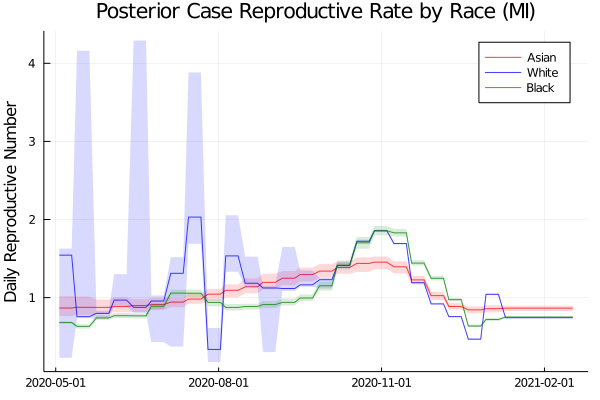

In [350]:
Rt_plot

In [351]:
savefig("../figs/RT_by_Race_" * STATE * ".pdf")